# Gradient Boosting

# Table of Content

<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('use_inf_as_na', True)

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb

from collections import Counter
import pickle

In [3]:
raw_data = pd.read_pickle(r'..\HW1_Decision Tree\dataset.pkl')
data = raw_data[raw_data['market_cap'] > 1000.0]
data.fillna(0.0,inplace=True)

C:\Users\Gulishana\Anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


## Define label: $y \in \{1,0,-1\}$
Insert a column in the data set with entries: (1) 1 if the stock return is more then 1% higher than the SPY return; (2) 0 if it is between -1% and 1%; (3) -1 if the stock underperforms the SPY by more than -1%

In [4]:
def f(x):
    if x > 0.01:
        return 1
    elif x < -0.01:
        return -1
    else:
        return 0

In [5]:
data['rel_performance'] = data['pred_rel_return'].apply(f)
data.reset_index(inplace=True,)
data.set_index('date',inplace=True)

C:\Users\Gulishana\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [6]:
start_dates = [pd.to_datetime('2000-01-01') + pd.DateOffset(months = 3 * i) for i in range(62)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
test_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]

training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

training_labels = [d['rel_performance'].values for d in training_frames]
validation_labels = [d['rel_performance'].values for d in test_frames]

## Gradient Boosting with 3rd set of hyperparameters

Here I use the a 3rd set of hyperparameters.
- `max_depth = 6`
- `min_data_in_leaf = 1500`
- `num_leaves = 15`
- `reg_lambda = 0.8`
- `learning_rate = 0.3`
- `n_estimators = 400`

Therefore, I will use this set of hyperparameters and combine it with different optimal features.

In [7]:
gb_clf = lgb.LGBMClassifier(max_depth=6, min_data_in_leaf=1500, num_leaves=15, objective='multi_class',
                            reg_lambda=0.8, learning_rate=0.3, n_estimators=400)

## Different combinations of hyperparameters and optimal features

### (1) Use optimal features given by `gb_opt_feat_1.pkl`

In [8]:
with open(r'opt_feature_files\gb_opt_feat_1.pkl','rb') as f: 
    optimal_features = pickle.load(f)

In [9]:
P_L = []
x = [0,1]
ret = []

for i in range(1,len(optimal_features)-1):

        gb_clf.fit(training_data[i][optimal_features[i-1]],training_labels[i])
        pred_i = gb_clf.predict(test_data[i][optimal_features[i-1]])
        
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        positions = np.sum(np.abs(pred_i))
        
        ret.append((1.0/positions) * profit_i)
        x.append(x[i] + (x[i]/positions) * profit_i)

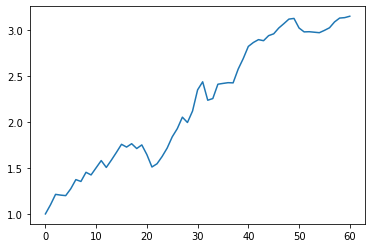

In [10]:
plt.plot(x[1:]);

In [11]:
SPY = pd.read_pickle(r'..\HW1_Decision Tree\SPY_cum_ret.pkl') 
SPY = SPY.loc['2003-10-01':]
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x[1:]

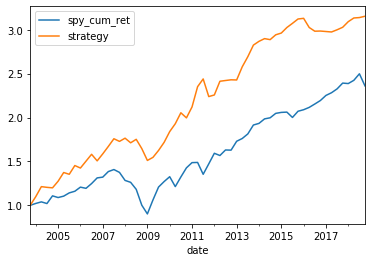

In [12]:
SPY.plot();

In [13]:
SPY = SPY.resample('A').bfill()

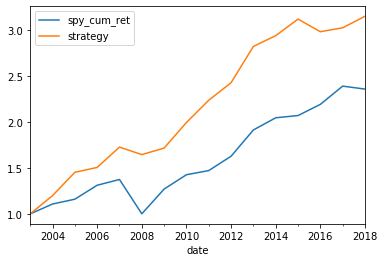

In [14]:
SPY.plot();

#### Compute strategy Sharpe Ratio

In [15]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  1.0324383390699163


#### Compute maximal yearly drawdown

In [16]:
def max_drawdown(returns):
        local_max = [n for n in range(len(returns)-1) if ((n==0) and (returns[0] > returns[1])) or 
           ((n > 0) and  (returns[n-1]<returns[n]) and (returns[n+1]<returns[n]))] 
        
        local_min = [n for n in range(1,len(returns)) if ((n == len(returns)-1) and (returns[-1] < returns[-2])) or
                (returns[n-1]>returns[n]) and (returns[n+1]>returns[n])]
        
        def next_local_min(n):
            if [m for m in local_min if m > n]:
                return [m for m in local_min if m > n][0]
            else: return None
        
        drawdowns = [(n,next_local_min(n)) for n in local_max]
        drawdown_values = [returns[n] - returns[m] for (n,m) in drawdowns if m != None]
        if drawdown_values:
            return  np.max(drawdown_values)
        else: return 0.0

In [17]:
starting_year='2010'
a = SPY.loc[starting_year]['spy_cum_ret'].values
b = SPY[starting_year]['strategy'].values

In [18]:
max_drawdown((SPY.loc[starting_year:]['strategy'] - b + 1).values)

0.137335486031968

In [19]:
def max_dd(returns):
    i = np.argmax(np.maximum.accumulate(returns) - returns)
    j = np.argmax(returns[:i])
    plt.plot(returns);
    plt.plot([i, j], [returns[i], returns[j]], 'o', color='Red', markersize=10)
    return np.abs(returns[j] - returns[i])

C:\Users\Gulishana\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


0.13733548603196777

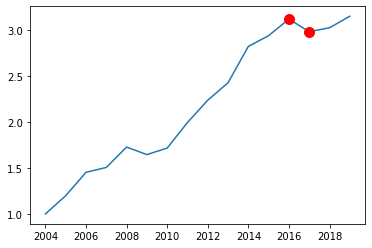

In [20]:
max_dd(SPY['strategy'])

### (2) Use optimal features given by `gb_opt_feat_2.pkl`

In [21]:
with open(r'opt_feature_files\gb_opt_feat_2.pkl','rb') as f: 
    optimal_features = pickle.load(f)

In [22]:
P_L = []
x = [0,1]
ret = []

for i in range(1,len(optimal_features)-1):

        gb_clf.fit(training_data[i][optimal_features[i-1]],training_labels[i])
        pred_i = gb_clf.predict(test_data[i][optimal_features[i-1]])
        
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        positions = np.sum(np.abs(pred_i))
        
        ret.append((1.0/positions) * profit_i)
        x.append(x[i] + (x[i]/positions) * profit_i)

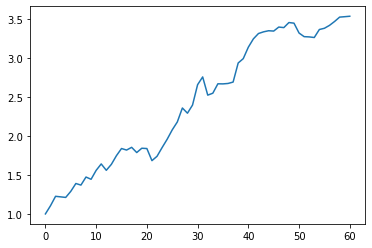

In [23]:
plt.plot(x[1:]);

In [24]:
SPY = pd.read_pickle(r'..\HW1_Decision Tree\SPY_cum_ret.pkl')
SPY = SPY.loc['2003-10-01':]
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x[1:]

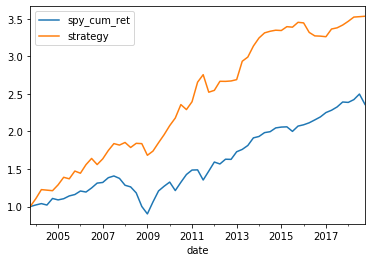

In [25]:
SPY.plot();

In [26]:
SPY = SPY.resample('A').bfill()

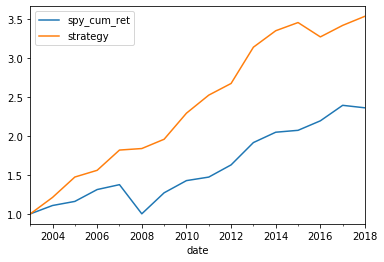

In [27]:
SPY.plot();

#### Compute strategy Sharpe Ratio

In [28]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  1.1482950314156832


#### Compute maximal yearly drawdown

In [29]:
starting_year='2010'
a = SPY.loc[starting_year]['spy_cum_ret'].values
b = SPY[starting_year]['strategy'].values

In [30]:
max_drawdown((SPY.loc[starting_year:]['strategy'] - b + 1).values)

0.18406009668572665

C:\Users\Gulishana\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


0.18406009668572665

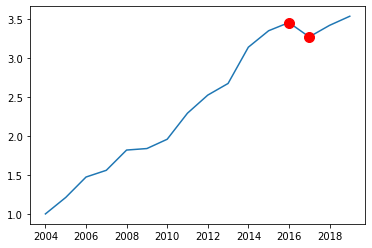

In [31]:
max_dd(SPY['strategy'])

### (3) Use optimal features given by `gb_opt_feat_3.pkl`

In [32]:
with open(r'opt_feature_files\gb_opt_feat_3.pkl','rb') as f:
    optimal_features = pickle.load(f)

In [33]:
P_L = []
x = [0,1]
ret = []

for i in range(1,len(optimal_features)-1):

        gb_clf.fit(training_data[i][optimal_features[i-1]],training_labels[i])
        pred_i = gb_clf.predict(test_data[i][optimal_features[i-1]])
        
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        positions = np.sum(np.abs(pred_i))
        
        ret.append((1.0/positions) * profit_i)
        x.append(x[i] + (x[i]/positions) * profit_i)

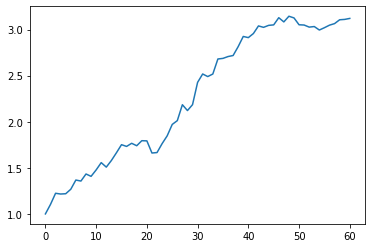

In [34]:
plt.plot(x[1:]);

In [35]:
SPY = pd.read_pickle(r'..\HW1_Decision Tree\SPY_cum_ret.pkl')
SPY = SPY.loc['2003-10-01':]
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x[1:]

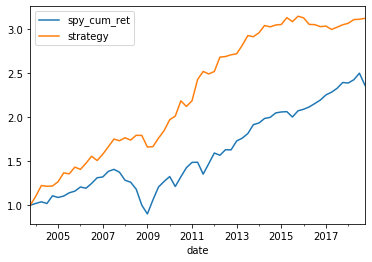

In [36]:
SPY.plot();

In [37]:
SPY = SPY.resample('A').bfill()

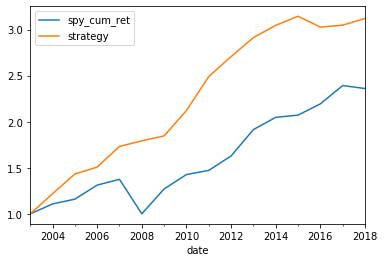

In [38]:
SPY.plot();

#### Compute strategy Sharpe Ratio

In [39]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  1.1703820156284053


#### Compute maximal yearly drawdown

In [40]:
starting_year='2010'
a = SPY.loc[starting_year]['spy_cum_ret'].values
b = SPY[starting_year]['strategy'].values

In [41]:
max_drawdown((SPY.loc[starting_year:]['strategy'] - b + 1).values)

0.11791755937442172

C:\Users\Gulishana\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


0.11791755937442172

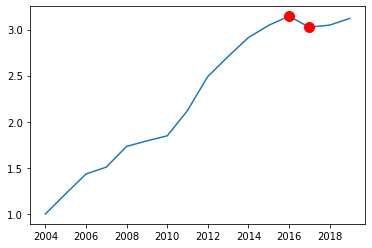

In [42]:
max_dd(SPY['strategy'])

## Results

- The best performing strategy is given by optimal feature set: `gb_opt_feat_3.pkl`
- Its yearly maximal drawdown is about 0.1179
- And its Sharpe Ratio is about 1.1704, which is larger than 1